<a href="https://colab.research.google.com/github/Vanh-29/b-i-gi-k-/blob/main/b%C3%A0i_t%E1%BA%ADp_gi%E1%BB%AFa_k%C3%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://14dfb3e56a62fb10a2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


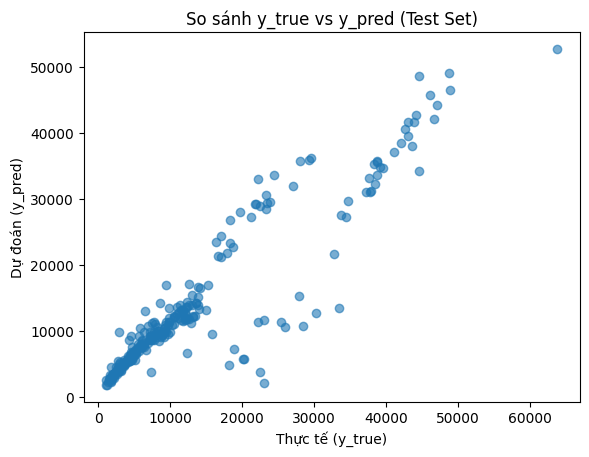

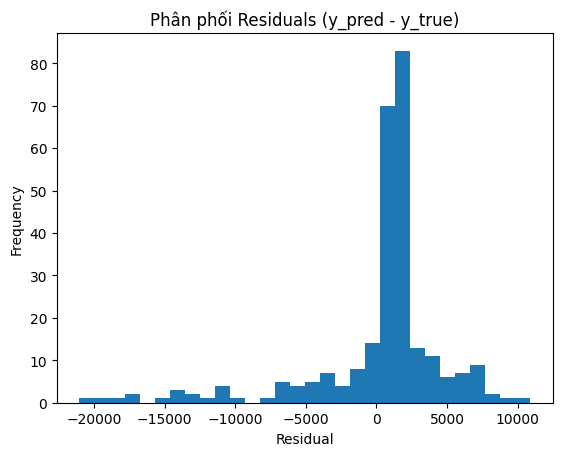

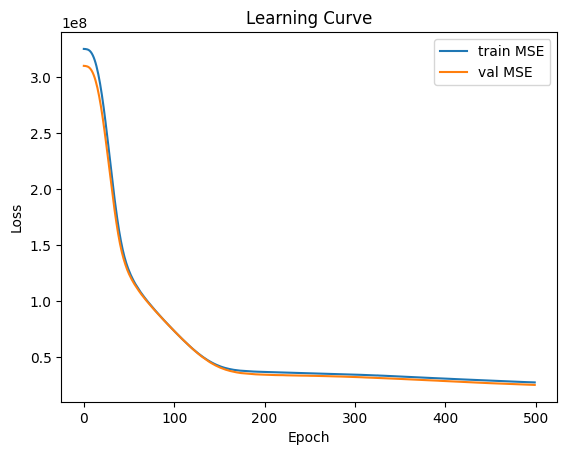

In [1]:
# app_gradio_full.py
# Gradio UI dự đoán chi phí bảo hiểm bằng ANN
# Có 4 tab: Dự đoán 1 bản ghi, Batch CSV, Báo cáo, Dự đoán toàn bộ dataset

import os
import tempfile
import urllib.request
from typing import Tuple, Dict, Any

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import gradio as gr

# -----------------------
# Config
# -----------------------
DATA_URL = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
CSV_FILE = "insurance.csv"
TARGET = "charges"
NUMERIC_COLS = ["age", "bmi", "children"]
CATEGORICAL_COLS = ["sex", "smoker", "region"]

# -----------------------
# Utils
# -----------------------
def ensure_dataset() -> pd.DataFrame:
    if not os.path.exists(CSV_FILE):
        urllib.request.urlretrieve(DATA_URL, CSV_FILE)
    return pd.read_csv(CSV_FILE)

def build_model(input_dim: int) -> tf.keras.Model:
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

def train_model(df: pd.DataFrame) -> Tuple[tf.keras.Model, ColumnTransformer, Dict[str, Any]]:
    X = df.drop(columns=[TARGET])
    y = df[TARGET].astype("float32")

    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), NUMERIC_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COLS),
    ])

    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    X_train = preprocessor.fit_transform(X_train_raw)
    X_test = preprocessor.transform(X_test_raw)

    model = build_model(X_train.shape[1])

    es = callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    ckpt = callbacks.ModelCheckpoint("ann_best.keras", monitor="val_loss", save_best_only=True)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=500, batch_size=32,
        callbacks=[es, ckpt],
        verbose=0
    )

    # Evaluate
    y_pred = model.predict(X_test).ravel()
    y_true_np = np.asarray(y_test, dtype=float).ravel()
    y_pred_np = np.asarray(y_pred, dtype=float).ravel()

    mae = mean_absolute_error(y_true_np, y_pred_np)
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = float(np.sqrt(mse))
    r2 = r2_score(y_true_np, y_pred_np)

    joblib.dump(preprocessor, "preprocessor.joblib")
    model.save("ann_last.keras")

    report = {
        "mae": float(mae),
        "rmse": float(rmse),
        "r2": float(r2),
        "y_true": y_true_np,
        "y_pred": y_pred_np,
        "history": history.history,
        "X_test_raw": X_test_raw.reset_index(drop=True),
    }
    return model, preprocessor, report

def make_learning_curve_fig(history: Dict[str, list]):
    fig = plt.figure()
    plt.plot(history["loss"], label="train MSE")
    plt.plot(history["val_loss"], label="val MSE")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    return fig

def make_scatter_fig(y_true: np.ndarray, y_pred: np.ndarray):
    fig = plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.xlabel("Thực tế (y_true)")
    plt.ylabel("Dự đoán (y_pred)")
    plt.title("So sánh y_true vs y_pred (Test Set)")
    return fig

def make_residual_fig(y_true: np.ndarray, y_pred: np.ndarray):
    residuals = y_pred - y_true
    fig = plt.figure()
    plt.hist(residuals, bins=30)
    plt.title("Phân phối Residuals (y_pred - y_true)")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    return fig

def predict_one(prep, model, age, sex, bmi, children, smoker, region) -> float:
    sample = pd.DataFrame([{
        "age": age, "sex": sex, "bmi": bmi, "children": children,
        "smoker": smoker, "region": region
    }])
    x = prep.transform(sample)
    return float(model.predict(x).ravel()[0])

def predict_batch(prep, model, file_obj):
    if file_obj is None:
        raise gr.Error("Vui lòng tải lên file CSV.")
    csv_path = file_obj.name if hasattr(file_obj, "name") else None
    if csv_path is None:
        raise gr.Error("Không đọc được file tải lên.")

    df_in = pd.read_csv(csv_path)
    required = set(NUMERIC_COLS + CATEGORICAL_COLS)
    missing = required - set(df_in.columns)
    if missing:
        raise gr.Error(f"Thiếu cột: {', '.join(sorted(missing))}")

    x = prep.transform(df_in[NUMERIC_COLS + CATEGORICAL_COLS])
    df_out = df_in.copy()
    df_out["predicted_charges"] = model.predict(x).ravel()

    tmp_out = os.path.join(tempfile.gettempdir(), "predicted_charges.csv")
    df_out.to_csv(tmp_out, index=False)
    return df_out, tmp_out

def predict_full_dataset(prep, model, df: pd.DataFrame):
    X = df.drop(columns=[TARGET])
    X_proc = prep.transform(X)
    df_out = df.copy()
    df_out["predicted_charges"] = model.predict(X_proc).ravel()
    tmp_path = os.path.join(tempfile.gettempdir(), "full_predictions.csv")
    df_out.to_csv(tmp_path, index=False)
    return df_out, tmp_path

# -----------------------
# Train khi app load
# -----------------------
df_global = ensure_dataset()
model_global, prep_global, report_global = train_model(df_global)

# -----------------------
# Gradio UI
# -----------------------
with gr.Blocks(title="Medical Cost ANN") as demo:
    gr.Markdown("# Medical Cost Prediction — ANN")

    with gr.Tabs():
        with gr.Tab("Dự đoán 1 bản ghi"):
            with gr.Row():
                age_in = gr.Number(label="Age", value=35, precision=0)
                sex_in = gr.Dropdown(choices=["male", "female"], value="male", label="Sex")
                bmi_in = gr.Number(label="BMI", value=28.0)
                children_in = gr.Number(label="Children", value=2, precision=0)
                smoker_in = gr.Dropdown(choices=["no", "yes"], value="yes", label="Smoker")
                region_in = gr.Dropdown(choices=["southwest", "southeast", "northwest", "northeast"],
                                        value="southeast", label="Region")
            btn_predict = gr.Button("Dự đoán")
            out_pred = gr.Number(label="Charges dự đoán (USD)", interactive=False)

            def _predict_wrapper(a, s, b, c, sm, r):
                return predict_one(prep_global, model_global, int(a), s, float(b), int(c), sm, r)

            btn_predict.click(_predict_wrapper,
                              [age_in, sex_in, bmi_in, children_in, smoker_in, region_in],
                              out_pred)

        with gr.Tab("Batch CSV"):
            file_in = gr.File(label="Tải lên CSV đầu vào", file_types=[".csv"])
            btn_batch = gr.Button("Tính dự đoán cho CSV")
            df_preview = gr.Dataframe(label="Kết quả (xem nhanh)")
            file_out = gr.File(label="Tải về kết quả CSV")

            def _batch_wrapper(fobj):
                df_out, out_path = predict_batch(prep_global, model_global, fobj)
                return df_out, out_path

            btn_batch.click(_batch_wrapper, [file_in], [df_preview, file_out])

        with gr.Tab("Báo cáo"):
            with gr.Row():
                gr.Markdown(f"**MAE:** ${report_global['mae']:,.0f}")
                gr.Markdown(f"**RMSE:** ${report_global['rmse']:,.0f}")
                gr.Markdown(f"**R²:** {report_global['r2']:.3f}")

            gr.Plot(make_scatter_fig(report_global["y_true"], report_global["y_pred"]))
            gr.Plot(make_residual_fig(report_global["y_true"], report_global["y_pred"]))
            gr.Plot(make_learning_curve_fig(report_global["history"]))

        with gr.Tab("Dự đoán toàn bộ dataset"):
            btn_full = gr.Button("Chạy dự đoán trên toàn bộ dữ liệu gốc")
            df_full = gr.Dataframe(label="50 dòng đầu kết quả")
            file_full = gr.File(label="Tải CSV đầy đủ")

            def _full_wrapper():
                df_out, path_out = predict_full_dataset(prep_global, model_global, df_global)
                return df_out.head(50), path_out

            btn_full.click(_full_wrapper, inputs=None, outputs=[df_full, file_full])

if __name__ == "__main__":
    demo.launch()
